# **LAB 5 - PART 1 Classification model (NN,CNN,LSTM) with Time Series Data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
import tensorflow as tf
from keras import Model , Input
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
import glob
from scipy import stats
import datetime as dt
from tqdm import tqdm

### **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load csv from txt files**

**- Load Acceleration**

In [ ]:
# Get filename of Acceleration

### START CODE HERE ###
import os

os.chdir("/content/drive/MyDrive/ML_Lab5")

fnames = glob.glob("*_acceleration.txt")

# Read CSV files
testers = []
for f in tqdm(fnames):
  tester = pd.read_csv(f,sep = " ",names=['timedelta', 'accX', 'accY', 'accZ'])
  testers.append(tester)

ACC = pd.concat(testers)

### END CODE HERE ###

100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


In [ ]:
ACC

,timedelta,accX,accY,accZ
0,-124489.161050,0.017487,-0.586700,-0.805771
1,-124489.116395,0.018982,-0.589676,-0.809158
2,-124489.115548,0.020966,-0.580887,-0.815048
3,-124489.114691,0.019485,-0.580872,-0.813583
4,-124489.097700,0.016998,-0.587204,-0.806259
...,...,...,...,...
1566995,37458.780511,-0.481201,-0.329498,-0.999710
1566996,37458.799774,-0.631622,-0.308197,-0.840958
1566997,37458.819445,-0.726898,-0.174835,-0.739563
1566998,37458.838677,-0.728760,0.052200,-0.852509


**- Load Heart Rate**

In [ ]:
# Get filename of HeartRate

### START CODE HERE ###

os.chdir("/content/drive/MyDrive/ML_Lab5")

fnames = glob.glob("*_heartrate.txt")

# Read CSV files
testers = []
for f in tqdm(fnames):
  tester = pd.read_csv(f,sep = ",",names=['timedelta', "heartRate"])
  testers.append(tester)

HeartR = pd.concat(testers)

### END CODE HERE ###

100%|██████████| 4/4 [00:00<00:00, 155.76it/s]


In [ ]:
HeartR
print(max(HeartR['heartRate']))

212.0


**- Load Labeled Sleep**

In [ ]:
# Get filename of sleep

### START CODE HERE ###

os.chdir("/content/drive/MyDrive/ML_Lab5")

fnames = glob.glob("*_labeled_sleep.txt")

# Read CSV files
testers = []
for f in tqdm(fnames):
  tester = pd.read_csv(f,sep = " ",names=['timedelta', 'sleep',])
  testers.append(tester)

SleepL = pd.concat(testers)

### END CODE HERE ###

100%|██████████| 4/4 [00:00<00:00, 234.88it/s]


**- If some Sleep levels are negative (-1) -> SleepL += 1**

In [ ]:
SleepL['sleep'] = SleepL['sleep'].where(SleepL['sleep'] >= 0, SleepL['sleep'] + 1)
SleepL


,timedelta,sleep
0,0,0
1,30,0
2,60,0
3,90,0
4,120,0
...,...,...
976,29280,5
977,29310,5
978,29340,5
979,29370,5


**Synchronizes 'ACC', 'HeartR', 'SleepL'** by aligning their time ranges, <br>
and then filters each dataset to only include data within the overlapping time range.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

<br> ACC start: -124489.16105       ACC end: 37458.8583889
<br> HeartR start: -604720.29398    HeartR end: 37541.70998
<br> SleepL start: 0                SleepL end: 29400


In [ ]:
### START CODE HERE ###

#Find max, min timedelta to find intersection time
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()

SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()


# Calculate intersection period
intersection_start = max(ACC_min_date, HeartR_min_date, SleepL_min_date)
intersection_end = min(ACC_max_date, HeartR_max_date, SleepL_max_date)


# Obtain data for ACC, HeartR, and SleepL exclusively during the intersection period.

ACC = ACC[(ACC['timedelta'] >= intersection_start) & (ACC['timedelta'] <= intersection_end)]
HeartR = HeartR[(HeartR['timedelta'] >= intersection_start) & (HeartR['timedelta'] <= intersection_end)]
SleepL = SleepL[(SleepL['timedelta'] >= intersection_start) & (SleepL['timedelta'] <= intersection_end)]
### END CODE HERE ###

If your code is correct, this cell will execute without any issues.

In [ ]:
print(ACC.shape)
print(HeartR.shape)
print(SleepL.shape)
# assert ACC.shape == (4863482, 4)
# assert HeartR.shape == (28655, 2)
# assert SleepL.shape == (2967, 2)

(4863482, 4)
(28655, 2)
(2972, 2)


Converts the `'timedelta'` column of the `ACC` DataFrame to a `pandas Timedelta object` in seconds and rounds it to the nearest second.

In [ ]:

### START CODE HERE ###
timedelta_unit = 's'  # Define the timedelta_unit variable
resample_rule = '1s'
ACC['timedelta'] = pd.to_timedelta(ACC['timedelta'], unit=timedelta_unit).round(resample_rule)
### END CODE HERE ###

ACC


<ipython-input-79-5f9ae1c7f93a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC['timedelta'] = pd.to_timedelta(ACC['timedelta'], unit=timedelta_unit).round(resample_rule)


,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
1507094,0 days 08:10:00,-0.328217,-0.088196,-0.925293
1507095,0 days 08:10:00,-0.326752,-0.083267,-0.923370
1507096,0 days 08:10:00,-0.334076,-0.058365,-0.943527
1507097,0 days 08:10:00,-0.313385,-0.054993,-0.953171


Groups the `ACC` DataFrame by `'timedelta'`, calculates the mean of `'accX', 'accY', and 'accZ'` for each group, and then concatenates these averages into a new DataFrame.

In [ ]:
### START CODE HERE ###
df_acc = ACC.groupby('timedelta').mean().reset_index()
ACC = df_acc
### END CODE HERE ###
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.143596,0.434711,-0.558406
1,0 days 00:00:01,-0.184721,0.438487,-0.492099
2,0 days 00:00:02,-0.213871,0.403676,-0.476563
3,0 days 00:00:03,-0.176616,0.391760,-0.571252
4,0 days 00:00:04,0.072789,0.338097,-0.571049
...,...,...,...,...
29396,0 days 08:09:56,-0.323531,-0.083234,-0.941430
29397,0 days 08:09:57,-0.326982,-0.089659,-0.939489
29398,0 days 08:09:58,-0.327790,-0.093318,-0.939144
29399,0 days 08:09:59,-0.327056,-0.084611,-0.940146


Converts the `'timedelta'` column of the `HeartR` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [ ]:
### START CODE HERE ###
HeartR['timedelta'] = pd.to_timedelta(HeartR['timedelta'], unit=timedelta_unit).round(resample_rule)
HeartR = HeartR.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
HeartR

,heartRate
timedelta,
0 days 00:00:02,65.0
0 days 00:00:03,65.0
0 days 00:00:04,65.0
0 days 00:00:05,65.0
0 days 00:00:06,65.0
...,...
0 days 08:09:55,50.0
0 days 08:09:56,50.0
0 days 08:09:57,50.0


Converts the `'timedelta'` column of the `SleepL` DataFrame to a `pandas Timedelta object` in seconds, rounds it to the nearest second, sets it as the index, resamples the DataFrame to 1-second intervals using median as the aggregation function, and forward fills any missing values.

In [ ]:
### START CODE HERE ###
SleepL['timedelta'] = pd.to_timedelta(SleepL['timedelta'] , unit=timedelta_unit).round(resample_rule)
resample_rule = '1s'
SleepL = SleepL.set_index('timedelta').resample(resample_rule).median().ffill()
### END CODE HERE ###
SleepL


,sleep
timedelta,
0 days 00:00:00,0.0
0 days 00:00:01,0.0
0 days 00:00:02,0.0
0 days 00:00:03,0.0
0 days 00:00:04,0.0
...,...
0 days 08:09:56,5.0
0 days 08:09:57,5.0
0 days 08:09:58,5.0


Merges the `ACC, HeartR, and SleepL` DataFrames into a single DataFrame df, aligning them based on their `'timedelta'` columns using an asof merge.

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	      timedelta	   accX	      accY	       accZ	  heartrate	sleep
0	0 days 00:00:00	-0.143596	0.434711	-0.558406	NaN	NaN
1	0 days 00:00:01	-0.184721	0.438487	-0.492099	NaN	NaN
2	0 days 00:00:02	-0.213871	0.403676	-0.476563	65.0	NaN
3	0 days 00:00:03	-0.176616	0.391760	-0.571252	65.0	NaN
4	0 days 00:00:04	0.072789	0.338097	-0.571049	65.0	NaN

```

In [ ]:
## START CODE HERE ###

df = pd.merge_asof(ACC, HeartR, on='timedelta')
df = pd.merge_asof(df, SleepL, on='timedelta')

### END CODE HERE ###
df

,timedelta,accX,accY,accZ,heartRate,sleep
0,0 days 00:00:00,-0.143596,0.434711,-0.558406,NaN,0.0
1,0 days 00:00:01,-0.184721,0.438487,-0.492099,NaN,0.0
2,0 days 00:00:02,-0.213871,0.403676,-0.476563,65.0,0.0
3,0 days 00:00:03,-0.176616,0.391760,-0.571252,65.0,0.0
4,0 days 00:00:04,0.072789,0.338097,-0.571049,65.0,0.0
...,...,...,...,...,...,...
29396,0 days 08:09:56,-0.323531,-0.083234,-0.941430,50.0,5.0
29397,0 days 08:09:57,-0.326982,-0.089659,-0.939489,50.0,5.0
29398,0 days 08:09:58,-0.327790,-0.093318,-0.939144,50.0,5.0
29399,0 days 08:09:59,-0.327056,-0.084611,-0.940146,50.0,5.0


Fills missing values in the `'heartrate'` column with the column's median,<br>
Fills missing values in the `'sleep'` column with 0,<br>
and then drops the `'timedelta'` column from the df DataFrame.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```
	   accX	      accY	      accZ	heartrate	sleep
0	-0.143596	0.434711	-0.558406	62.0	0.0
1	-0.184721	0.438487	-0.492099	62.0	0.0
2	-0.213871	0.403676	-0.476563	65.0	0.0
3	-0.176616	0.391760	-0.571252	65.0	0.0
4	0.072789	0.338097	-0.571049	65.0	0.0
```

In [ ]:
### START CODE HERE ###
df['heartRate'] = df['heartRate'].fillna(HeartR['heartRate'].median())
df['sleep'] = df['sleep'].fillna(0)
df.drop(columns=["timedelta"],inplace = True)

### END CODE HERE ###
df

,accX,accY,accZ,heartRate,sleep
0,-0.143596,0.434711,-0.558406,62.0,0.0
1,-0.184721,0.438487,-0.492099,62.0,0.0
2,-0.213871,0.403676,-0.476563,65.0,0.0
3,-0.176616,0.391760,-0.571252,65.0,0.0
4,0.072789,0.338097,-0.571049,65.0,0.0
...,...,...,...,...,...
29396,-0.323531,-0.083234,-0.941430,50.0,5.0
29397,-0.326982,-0.089659,-0.939489,50.0,5.0
29398,-0.327790,-0.093318,-0.939144,50.0,5.0
29399,-0.327056,-0.084611,-0.940146,50.0,5.0


1. Separate X input[['accX', 'accY', 'accZ', 'heartrate'] ]and Y output[['sleep']]
2. Perform data scaling using Standardize,<br>
3. Perform SMA: Simple Moving Average to reduce noise in signals ,<br>

In [ ]:
### START CODE HERE ###
feature_columns = ["accX", "accY", "accZ","heartRate"]
label_columns = ["sleep"]

df_feature = df[feature_columns]
df_label = df[label_columns]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_feature)

df_feature_SMA = pd.DataFrame(scaled_features, columns=feature_columns)
wsize = 10
minp = 1
df_feature_SMA['accX'] = df_feature_SMA['accX'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accY'] = df_feature_SMA['accY'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['accZ'] = df_feature_SMA['accZ'].rolling(wsize, min_periods=minp).mean()
df_feature_SMA['heartRate'] = df_feature_SMA['heartRate'].rolling(wsize, min_periods=minp).mean()
### END CODE HERE ###

In [ ]:
df_feature_SMA

,accX,accY,accZ,heartRate
0,0.496332,2.235051,-0.451235,0.078284
1,0.343365,2.242844,-0.368859,0.078284
2,0.220094,2.197544,-0.328534,0.159064
3,0.227744,2.162598,-0.367188,0.199453
4,0.603402,2.097329,-0.390281,0.223687
...,...,...,...,...
29396,-0.865831,0.087162,-1.399265,-1.036468
29397,-0.863473,0.084934,-1.399368,-1.012235
29398,-0.864497,0.080104,-1.399055,-0.988001
29399,-0.863251,0.082978,-1.399486,-0.963767


In [ ]:
print(max(df_feature_SMA['heartRate']))

2.542049552963463


Graph of all signals before and after Standardize and SMA
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)

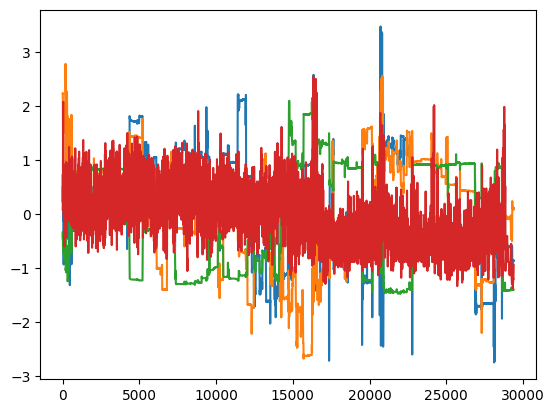

In [ ]:
### START CODE HERE ###
# Before Standardize and SMA
# plt.plot(df)
# After
plt.plot(df_feature_SMA)
plt.show()
### END CODE HERE ###

In [ ]:
print(df_label)

       sleep
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
...      ...
29396    5.0
29397    5.0
29398    5.0
29399    5.0
29400    5.0

[29401 rows x 1 columns]


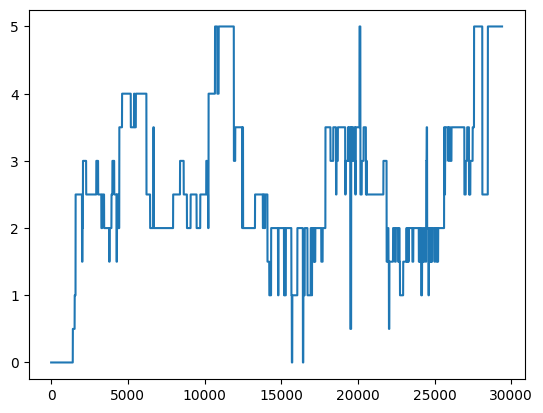

In [ ]:
# Graph Sleep labels
plt.plot(df_label)

### **Model Experimentaion**

**Train Test Data Preparation**

In [ ]:
X = df_feature_SMA
Y = df_label

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.5,  test_size = 0.3, random_state = 42)

##### **Neural Network**
**Create MLP (NN) Model Architecture**

In [ ]:
y_train = y_train.astype(int)

In [ ]:
print(x_train)

           accX      accY      accZ  heartRate
19733 -1.252631  1.494324 -1.231017  -0.067118
2146   0.251413  0.681331  0.821400  -0.038845
22371  1.393796  0.722743 -1.447891  -0.648728
27075 -1.707512 -1.307601  0.294473  -0.309456
11307  0.955036  0.036400 -1.204911   1.108219
...         ...       ...       ...        ...
16526 -1.100694 -0.853721  0.673457  -0.224637
6771   0.233424 -1.401916 -0.028178  -0.834520
25589 -0.344057  0.545138  0.918404  -0.664884
6992   0.329616  0.750082  0.535804   0.041934
23825 -0.751862  1.012893  0.919835  -0.648728

[14700 rows x 4 columns]


In [ ]:
hiddenL = (50,50,50 )
act = 'relu'
EP = 100
lr = 0.001
optimizer = 'adam'
SEED_init = 42
tolr = 1e-4
mlp = MLPClassifier(hidden_layer_sizes=hiddenL,
                    activation=act,
                    max_iter=EP,
                    alpha=lr,
                    solver=optimizer,
                    random_state=SEED_init,
                    tol=tolr)
mlp

MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50, 50), max_iter=100,
              random_state=42)

**Traning MLP (NN) Model**

In [ ]:
mlp.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50, 50), max_iter=100,
              random_state=42)

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

```----- Classification Report of MLP NN predict X_test -----
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       192
           1       0.86      0.73      0.79      1246
           2       0.77      0.35      0.48      1224
           3       0.84      0.82      0.83      4153
           4       0.64      0.75      0.69       603
           5       0.88      0.88      0.88      1403

   micro avg       0.83      0.74      0.78      8821
   macro avg       0.80      0.71      0.74      8821
weighted avg       0.82      0.74      0.77      8821
 samples avg       0.73      0.74      0.73      8821
```
![image-2.png](attachment:image-2.png)

**MLP (NN) Model Prediction**

In [ ]:
y_pred = mlp.predict(x_test)

y_pred

array([1, 5, 2, ..., 3, 2, 5])

**MLP (NN) Model Performance (Confusion Matrix, Classification_report)**


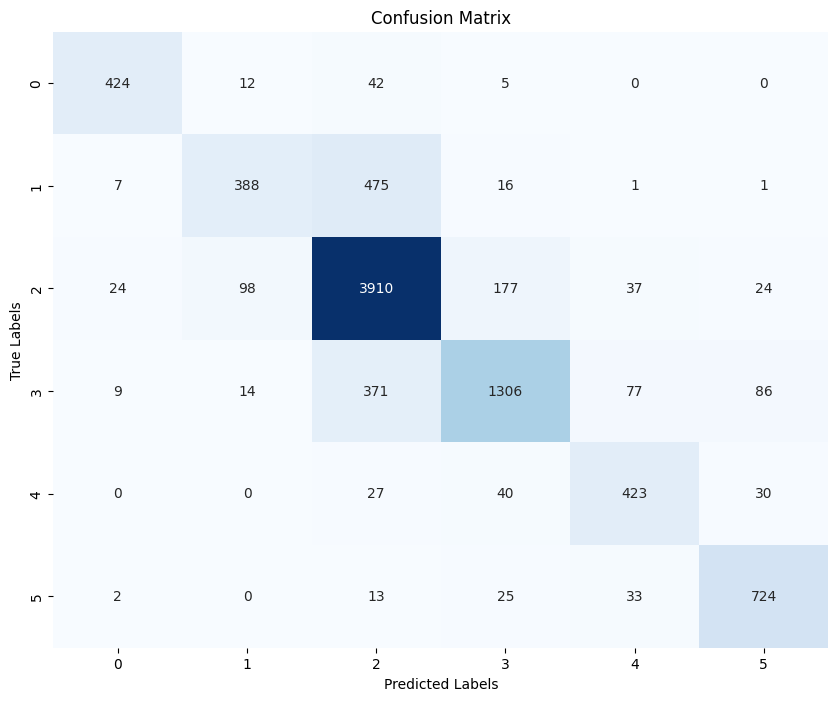

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       483
           1       0.76      0.44      0.55       888
           2       0.81      0.92      0.86      4270
           3       0.83      0.70      0.76      1863
           4       0.74      0.81      0.78       520
           5       0.84      0.91      0.87       797

    accuracy                           0.81      8821
   macro avg       0.81      0.78      0.79      8821
weighted avg       0.81      0.81      0.81      8821



In [ ]:
cm = confusion_matrix(y_test['sleep'].values.astype(int),y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test['sleep'].values.astype(int), y_pred))

##### **Train-Test Data Preparation for CNN Training**
1. Non-Transpose Data (XR Shape1: sliding window size, n_feature)
2. Transpose Data  (XT Shape2: n_feature, sliding window size)

**Non-Transpose data (XR)**



In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ,
stride = 10
X = df_feature_SMA

XR = []
y = []
# XR = [n_feature, slidingW, n_feature, 1]
# y = [n_feature, n_feature, slidingW, 1]
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote : mode of labels for whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
yR = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yR
y = pd.get_dummies(yR["Sleep_Label"])
yR = y

In [ ]:
yR

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2926,0,0,0,0,0,0,0,0,0,1
2927,0,0,0,0,0,0,0,0,0,1
2928,0,0,0,0,0,0,0,0,0,1
2929,0,0,0,0,0,0,0,0,0,1


**Non-Transpose Tran_test_split data**

In [ ]:
#----- CNN with XR -----------
#--- Train - Validate - Test ----
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state = 42)

##### **CNN Architecture (XR)**

In [ ]:
yR.shape

(2931, 10)

In [ ]:
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yR.shape

pDrop = 0.4

Input_shape = (slidingW, n_feature, 1)
P_size = (2,1)

model = Sequential()
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func, padding='same', input_shape=Input_shape))
model.add(MaxPooling2D(pool_size = P_size))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size = P_size ))
model.add(Dropout(pDrop))

model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D( pool_size = P_size))
model.add(Dropout(pDrop))

model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass[1], activation='sigmoid'))

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy,
              metrics=["acc"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 4, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 4, 16)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 50, 4, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 4, 64)         9280      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 25, 4, 64)         0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 25, 4, 64)        

##### **Train CNN(XR)**

In [ ]:
yR.shape

(2931, 10)

In [ ]:
# historyXR = model.fit()
historyXR = model.fit(XR_train, yR_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
52/52 [==============================] - 5s 76ms/step - loss: 1.8902 - acc: 0.3006 - val_loss: 1.6562 - val_acc: 0.4988
Epoch 2/10
52/52 [==============================] - 3s 65ms/step - loss: 1.4543 - acc: 0.4378 - val_loss: 1.3108 - val_acc: 0.5328
Epoch 3/10
52/52 [==============================] - 4s 68ms/step - loss: 1.2309 - acc: 0.5165 - val_loss: 1.2519 - val_acc: 0.5255
Epoch 4/10
52/52 [==============================] - 4s 76ms/step - loss: 1.0890 - acc: 0.5549 - val_loss: 1.1223 - val_acc: 0.5377
Epoch 5/10
52/52 [==============================] - 3s 65ms/step - loss: 1.0119 - acc: 0.5957 - val_loss: 1.0614 - val_acc: 0.5742
Epoch 6/10
52/52 [==============================] - 4s 68ms/step - loss: 0.9513 - acc: 0.6189 - val_loss: 1.0167 - val_acc: 0.5572
Epoch 7/10
52/52 [==============================] - 4s 79ms/step - loss: 0.8597 - acc: 0.6518 - val_loss: 0.9055 - val_acc: 0.6399
Epoch 8/10
52/52 [==============================] - 3s 65ms/step - loss: 0.7985 - a

##### **CNN (XR) Performance**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

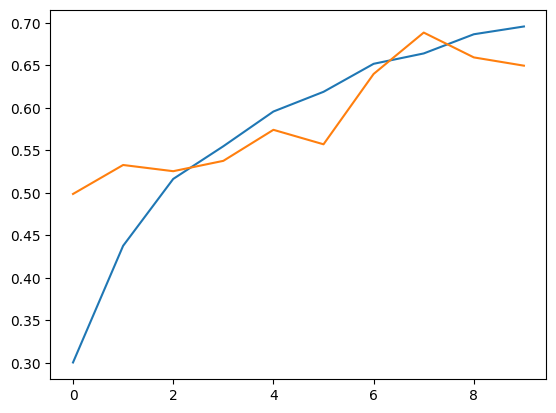

In [ ]:
# summarize history for accuracy
history = historyXR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

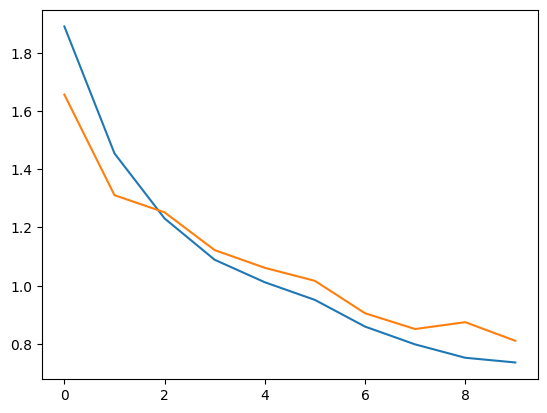

In [ ]:
# summarize history for loss
history=historyXR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)

```
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.91      0.92      0.91       125
           2       0.82      0.67      0.74       127
           3       0.87      0.90      0.89       419
           4       0.72      0.76      0.74        58
           5       0.85      0.87      0.86       134

    accuracy                           0.86       880
   macro avg       0.86      0.85      0.86       880
weighted avg       0.86      0.86      0.86       880
```

In [ ]:
yR_labels = np.argmax(yR_test.values, axis=1)
yR_labels = pd.DataFrame(yR_labels,columns = ["Label"])
yR_labels

# yR_test

,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,8
876,4
877,4
878,4


In [ ]:
CNN_pred = model.predict(XR_test)
# print(CNN_pred)
CNN_pred = np.argmax(CNN_pred, axis=1)
CNN_pred_df = pd.DataFrame(CNN_pred,columns = ["Label"])
CNN_pred_df
# yR_labels = np.argmax(yR_test.values, axis=1)

# print(yR_labels)

28/28 [==============================] - 0s 15ms/step


,Label
0,5
1,4
2,6
3,5
4,4
...,...
875,8
876,4
877,5
878,5


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.83      0.91         6
           2       0.09      0.80      0.17         5
           3       0.31      0.52      0.38        29
           4       0.82      0.62      0.71       318
           5       0.74      0.68      0.71       200
           6       0.06      0.40      0.10        10
           7       0.71      0.67      0.69       134
           8       0.84      0.70      0.76        66
           9       0.79      0.76      0.77        79

    accuracy                           0.67       880
   macro avg       0.63      0.70      0.62       880
weighted avg       0.76      0.67      0.71       880

----- Confusion matrix of CNN predict X_test -----


<Axes: >

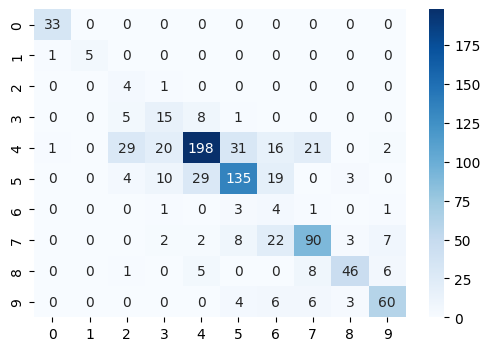

In [ ]:
# print('----- Classification Report of CNN predict X_test -----')
# CNN_pred = model.predict(XR_test)

print(classification_report(CNN_pred_df,yR_labels))
print('----- Confusion matrix of CNN predict X_test -----')
# print(confusion_matrix(CNN_pred_df,yR_labels))

cm = confusion_matrix(CNN_pred_df,yR_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### **Transpose data (XT)**

In [ ]:
yR_labels = np.argmax(yR.values,axis = 1)
yR_labels = pd.DataFrame(yR_labels,columns = ["Label"])
yR_labels
# yR_labels = np.argmax(yR_test.values, axis=1)
# yR_labels

,Label
0,0
1,0
2,0
3,0
4,0
...,...
2926,9
2927,9
2928,9
2929,9


In [ ]:
yR

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2926,0,0,0,0,0,0,0,0,0,1
2927,0,0,0,0,0,0,0,0,0,1
2928,0,0,0,0,0,0,0,0,0,1
2929,0,0,0,0,0,0,0,0,0,1


In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = X.iloc[i: i + slidingW].values
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW,1)
    # label sliding windows = df_label[i:i+slidingW]
    labels = Y.iloc[i: i + slidingW].values
    # print(labels)
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(labels, axis=None)
    # print(mode_values)
    label = mode_values

    XT.append(featureT)
    y.append(label)


XT = np.array(XT)
yT = pd.DataFrame(np.array(y), columns=['Sleep_Label'])
# One hot encoding yT
yT_encoded = pd.get_dummies(yT['Sleep_Label'])



In [ ]:
yT_encoded

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2926,0,0,0,0,0,0,0,0,0,1
2927,0,0,0,0,0,0,0,0,0,1
2928,0,0,0,0,0,0,0,0,0,1
2929,0,0,0,0,0,0,0,0,0,1


##### **Train Test Split (XT)**

In [ ]:
#----- CNN with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT_encoded, test_size=0.3,random_state=42)

##### **CNN Architecture (XT)**

In [ ]:
yT_encoded.shape

(2931, 10)

In [ ]:
CNN_L1 = 16
CNN_L2 = 64
CNN_L3 = 128
Ker_size = (3,3)
Act_func = "relu"
Dense_size = 512
Nclass = yT_encoded.shape

pDrop = 0.4

Input_shape = (n_feature, slidingW, 1)
P_size = (1,2)

model = Sequential()

#Conv layer#1
model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func, padding='same', input_shape=Input_shape))
model.add(MaxPooling2D(pool_size = P_size))
model.add(Dropout(pDrop))

#Conv layer#2
model.add(Conv2D(CNN_L2, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D(pool_size = P_size ))
model.add(Dropout(pDrop))

#Conv layer#2
model.add(Conv2D(CNN_L3, kernel_size=Ker_size, activation=Act_func, padding='same'))
model.add(MaxPooling2D( pool_size = P_size))
model.add(Dropout(pDrop))

# Flatten: Convert to 1D vector
model.add(Flatten())
model.add(Dense(Dense_size, activation=Act_func))
model.add(Dense(Nclass[1], activation='sigmoid'))

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy,
              metrics=["acc"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 4, 100, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 4, 50, 16)         0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 4, 50, 16)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 50, 64)         9280      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 4, 25, 64)         0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 4, 25, 64)        

##### **Train CNN (XT)**

In [ ]:
yT.shape

(2931, 1)

In [ ]:
historyXT = model.fit(XT_train, yT_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
52/52 [==============================] - 4s 68ms/step - loss: 1.8049 - acc: 0.3348 - val_loss: 1.5984 - val_acc: 0.4331
Epoch 2/10
52/52 [==============================] - 3s 67ms/step - loss: 1.4290 - acc: 0.4482 - val_loss: 1.2970 - val_acc: 0.5328
Epoch 3/10
52/52 [==============================] - 4s 74ms/step - loss: 1.2555 - acc: 0.5171 - val_loss: 1.1716 - val_acc: 0.5766
Epoch 4/10
52/52 [==============================] - 3s 65ms/step - loss: 1.0982 - acc: 0.5579 - val_loss: 1.0615 - val_acc: 0.5985
Epoch 5/10
52/52 [==============================] - 3s 64ms/step - loss: 0.9752 - acc: 0.6024 - val_loss: 0.9974 - val_acc: 0.6521
Epoch 6/10
52/52 [==============================] - 4s 78ms/step - loss: 0.9123 - acc: 0.6220 - val_loss: 0.9828 - val_acc: 0.6350
Epoch 7/10
52/52 [==============================] - 3s 65ms/step - loss: 0.8582 - acc: 0.6634 - val_loss: 0.8977 - val_acc: 0.6521
Epoch 8/10
52/52 [==============================] - 4s 72ms/step - loss: 0.7644 - a

##### **CNN Performance (XT)**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

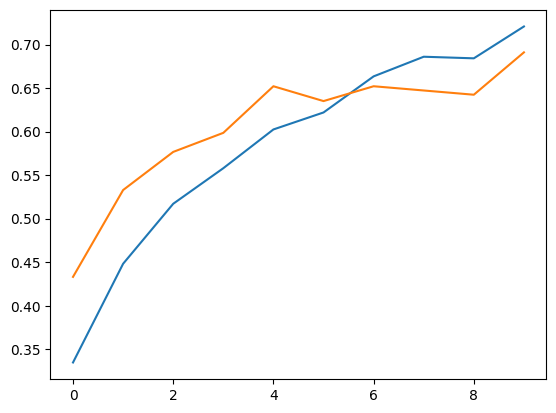

In [ ]:
# summarize history for accuracy
history = historyXT
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

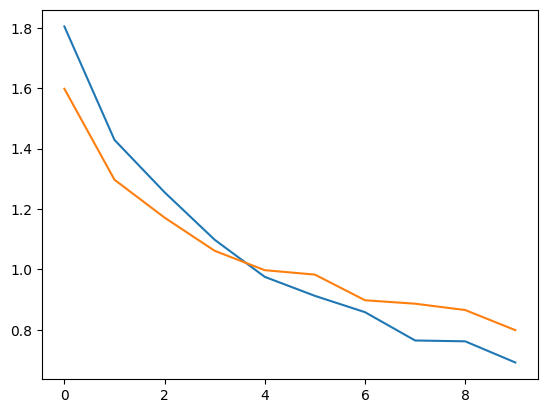

In [ ]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)

```
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.88      0.88      0.88       125
           2       0.76      0.54      0.63       127
           3       0.83      0.89      0.86       419
           4       0.72      0.67      0.70        58
           5       0.82      0.90      0.86       134

    accuracy                           0.82       880
   macro avg       0.83      0.80      0.81       880
weighted avg       0.82      0.82      0.82       880
```

In [ ]:
yT_test

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,5.0
1357,0,0,0,0,0,1,0,0,0,0
2367,0,0,0,0,1,0,0,0,0,0
2822,0,0,0,0,0,1,0,0,0,0
2126,0,0,0,0,0,1,0,0,0,0
1544,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
497,0,0,0,0,0,0,0,0,1,0
2382,0,0,0,0,1,0,0,0,0,0
325,0,0,0,0,1,0,0,0,0,0
342,0,0,0,0,1,0,0,0,0,0


In [ ]:
yT_labels = np.argmax(yT_test.values, axis=1)
yT_labels = pd.DataFrame(yT_labels,columns = ["Label"])
yT_labels


,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,8
876,4
877,4
878,4


In [ ]:
CNN_pred = model.predict(XT_test)
CNN_pred = np.argmax(CNN_pred, axis=1)
CNN_pred_df = pd.DataFrame(CNN_pred,columns = ["Label"])
CNN_pred_df



28/28 [==============================] - 0s 14ms/step


,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,7
876,4
877,5
878,5


28/28 [==============================] - 0s 14ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      0.71      0.83         7
           2       0.49      0.68      0.57        31
           3       0.27      0.48      0.34        27
           4       0.73      0.74      0.74       239
           5       0.86      0.66      0.75       235
           6       0.13      0.36      0.20        25
           7       0.84      0.63      0.72       167
           8       0.53      0.50      0.51        58
           9       0.57      0.74      0.64        58

    accuracy                           0.67       880
   macro avg       0.64      0.65      0.63       880
weighted avg       0.73      0.67      0.69       880

----- Confusion matrix of CNN predict X_test -----
[[ 33   0   0   0   0   0   0   0   0   0]
 [  1   5   1   0   0   0   0   0   0

<Axes: >

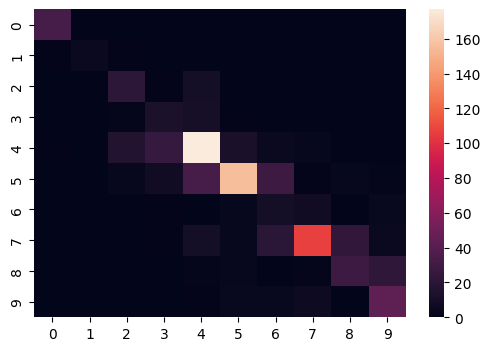

In [ ]:
CNN_pred = model.predict(XT_test)

print('----- Classification Report of CNN predict X_test -----')
print(classification_report(CNN_pred_df,yT_labels))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(CNN_pred_df,yT_labels))

cm = confusion_matrix(CNN_pred_df,yT_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm)

### **Long Short Term Memory (LSTM)**

**Train-Test Data Preparation**
LSTM Use data XR, XT same as CNN

##### **Prepare (XR) Data**

In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ,
stride = 10
X = df_feature_SMA

XR = []
y = []
# XR = [n_feature, slidingW, n_feature, 1]
# y = [n_feature, n_feature, slidingW, 1]
for i in range(0, len(X)-slidingW, stride_step):
    # sliding window X[i: i+slidingW]
    feature = np.array(X.iloc[i: i+slidingW])
    # Reshape 2D Array to 3D Array with channel last
    featureR = feature.reshape(slidingW, n_feature, 1)
    # sliding window df_labels[i: i+slidingW]
    label = np.array(Y.iloc[i: i+slidingW])
    # Majority vote : mode of labels for whole array
    mode_values, countL = stats.mode(label,axis=None)
    label = mode_values

    XR.append(featureR)
    y.append(label)

XR = np.array(XR)
yR = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yR
y = pd.get_dummies(yR["Sleep_Label"])
yR = y

In [ ]:
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=0.3,random_state = 42)

##### **LSTM (XR) Model Architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Define the number of nodes for the LSTM layers
Nodes = [50, 100, 150, 200, 250, 300, 400, 500, 1000]
n_hidden1 = Nodes[0]  # Choose the desired number of nodes for the first LSTM layer
n_hidden2 = Nodes[1]  # Choose the desired number of nodes for the second LSTM layer

# Assuming yR is your output labels DataFrame
Nclass = yR.shape[1]  # Assuming yR.shape[1] represents the number of classes

Input_shape = (slidingW, n_feature)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(0.2))  # Add dropout layer with 20% dropout rate

model.add(LSTM(n_hidden2))
model.add(Dropout(0.2))  # Add dropout layer with 20% dropout rate

model.add(Dense(Nclass, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           11000     
                                                                 
 dropout_16 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
Total params: 72410 (282.85 KB)
Trainable params: 72410 (282.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 300, 400, 500, 1000]
n_hidden1 = Nodes[0]
n_hidden2 = Nodes[2]
dropRate_L1 = 0.25
dropRate_L2 = 0.5

Nclass = yR.shape[1]
Input_shape = (slidingW, n_feature)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(dropRate_L1))

model.add(LSTM(n_hidden2))
model.add(Dropout(dropRate_L2))

model.add(Dense(Nclass, activation='softmax'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           11000     
                                                                 
 dropout_18 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 150)               120600    
                                                                 
 dropout_19 (Dropout)        (None, 150)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1510      
                                                                 
Total params: 133110 (519.96 KB)
Trainable params: 133110 (519.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy,
              metrics=["acc"])

##### **Training LSTM (XR) Model**

In [ ]:
# Training the model

EP = 10
batch_size = 32

historyL_XR = model.fit(XR_train, yR_train, epochs=EP, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
52/52 [==============================] - 9s 120ms/step - loss: 1.9100 - acc: 0.2945 - val_loss: 1.6105 - val_acc: 0.4063
Epoch 2/10
52/52 [==============================] - 6s 121ms/step - loss: 1.6697 - acc: 0.3555 - val_loss: 1.4685 - val_acc: 0.4623
Epoch 3/10
52/52 [==============================] - 6s 112ms/step - loss: 1.4815 - acc: 0.4421 - val_loss: 1.3725 - val_acc: 0.5134
Epoch 4/10
52/52 [==============================] - 6s 122ms/step - loss: 1.4105 - acc: 0.4634 - val_loss: 1.3642 - val_acc: 0.4745
Epoch 5/10
52/52 [==============================] - 6s 108ms/step - loss: 1.3210 - acc: 0.5079 - val_loss: 1.1882 - val_acc: 0.5669
Epoch 6/10
52/52 [==============================] - 6s 122ms/step - loss: 1.3349 - acc: 0.4982 - val_loss: 1.1995 - val_acc: 0.5450
Epoch 7/10
52/52 [==============================] - 6s 107ms/step - loss: 1.2537 - acc: 0.5226 - val_loss: 1.1906 - val_acc: 0.5474
Epoch 8/10
52/52 [==============================] - 9s 170ms/step - loss: 1.

 **LSTM (XR) Model Performance**

<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image-3.png](attachment:image-3.png)

![image-4.png](attachment:image-4.png)

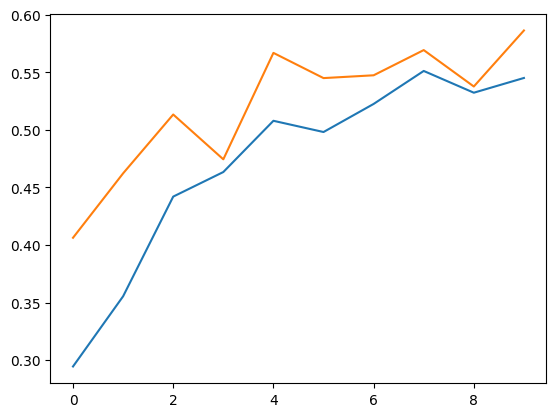

In [ ]:
# summarize history for accuracy
history = historyL_XR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


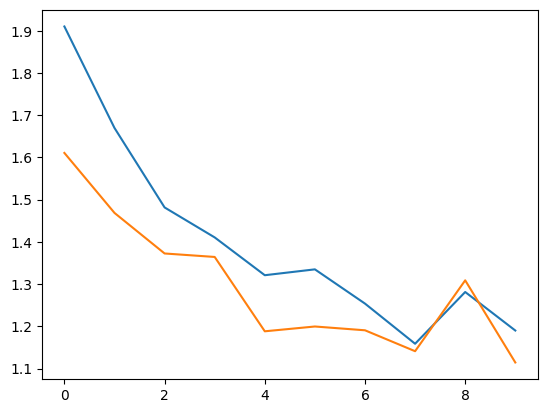

In [ ]:
# summarize history for loss
history = historyL_XR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


**Try to predict classes using the test dataset. Then, plot the confusion matrix and print the classification report.**
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

![image.png](attachment:image.png)

```
             precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.80      0.72      0.76       125
           2       0.49      0.28      0.36       127
           3       0.72      0.86      0.79       419
           4       0.00      0.00      0.00        58
           5       0.65      0.85      0.74       134

    accuracy                           0.70       880
   macro avg       0.60      0.61      0.60       880
weighted avg       0.65      0.70      0.66       880

```

In [ ]:
LSTM_pred = model.predict(XR_test)
LSTM_pred = np.argmax(LSTM_pred, axis=1)
LSTM_pred_df = pd.DataFrame(LSTM_pred,columns = ["Label"])
LSTM_pred_df



28/28 [==============================] - 1s 33ms/step


,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,8
876,4
877,5
878,5


In [ ]:
yR_labels = np.argmax(yR_test.values, axis=1)
yR_labels = pd.DataFrame(yR_labels,columns = ["Label"])
yR_labels

,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,8
876,4
877,4
878,4


28/28 [==============================] - 1s 44ms/step
----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.89      0.67      0.77        46
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.14      0.41      0.21        17
           4       0.69      0.55      0.61       303
           5       0.76      0.44      0.56       315
           6       0.00      0.00      0.00         0
           7       0.52      0.63      0.57       104
           8       0.67      0.71      0.69        52
           9       0.43      0.77      0.55        43

    accuracy                           0.54       880
   macro avg       0.41      0.42      0.40       880
weighted avg       0.68      0.54      0.59       880

----- Confusion matrix of CNN predict X_test -----
[[ 31   2   3   0   0   8   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

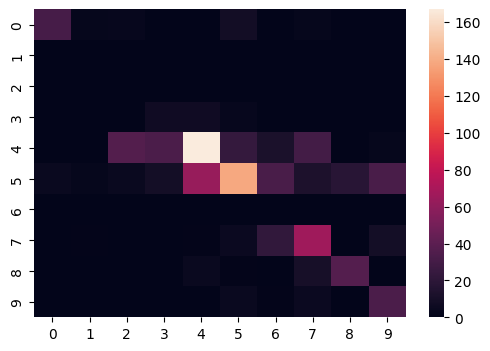

In [ ]:
LSTM_pred = model.predict(XR_test)

print('----- Classification Report of CNN predict X_test -----')
print(classification_report(LSTM_pred_df,yR_labels))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(LSTM_pred_df,yR_labels))

cm = confusion_matrix(LSTM_pred_df,yR_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm)

##### **Prepare (XT) Data**

In [ ]:
slidingW = 100
stride_step = 10
n_feature = 4 # accX, accY, accZ, HeartH

X = df_feature_SMA

XT = []
y = []
for i in range(0, len(X)-slidingW, stride_step):
    # X sliding windows X[i: i+]
    feature = X.iloc[i: i + slidingW].values
    # feature transpose
    featureT = np.transpose(feature)
    # reshape to 3D with channel las=1
    featureT = featureT.reshape(n_feature, slidingW,1)
    # label sliding windows = df_label[i:i+slidingW]
    labels = Y.iloc[i: i + slidingW].values
    # Majority vote labels using mode() #whole array
    mode_values, countL = stats.mode(labels, axis=None)
    label = mode_values

    XT.append(featureT)
    y.append(label)

XT = np.array(XT)
yT = pd.DataFrame(np.array(y).ravel(),columns=['Sleep_Label'])
# one hot encoding yT
y = pd.get_dummies(yT['Sleep_Label'])
yT = y

In [ ]:
#----- LSTM with XT -----------
#--- Train - Validate - Test ----
XT_train, XT_test, yT_train, yT_test = train_test_split(XT, yT, test_size=0.3,random_state=42)


##### **Create LSTM (XT) Model Architecture**

In [ ]:
#LSTM 2 Layers
Nodes = [50, 100, 150, 200, 250, 300, 400, 500, 1000]
n_hidden1 = Nodes[0]
n_hidden2 = Nodes[1]
pv1 = 0.25
pv2 = 0.5

Nclass = yT.shape
Input_shape = (n_feature, slidingW)
print(Input_shape)

model = Sequential()
model.add(LSTM(n_hidden1, return_sequences=True, input_shape=Input_shape))
model.add(Dropout(pv1))

model.add(LSTM(n_hidden2))
model.add(Dropout(pv2))
model.add(Dense(Nclass[1], activation='softmax'))
model.summary()

(4, 100)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 4, 50)             30200     
                                                                 
 dropout_22 (Dropout)        (None, 4, 50)             0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                1010      
                                                                 
Total params: 91610 (357.85 KB)
Trainable params: 91610 (357.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Training Parameters (optimizer)**

In [ ]:
# Training the model
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss= tf.keras.losses.categorical_crossentropy,
              metrics=["acc"])

EP = 10
batch_size = 32
historyL_XT = model.fit(XT_train, yT_train, epochs=EP, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
52/52 [==============================] - 6s 25ms/step - loss: 2.0545 - acc: 0.2841 - val_loss: 1.8639 - val_acc: 0.3747
Epoch 2/10
52/52 [==============================] - 0s 6ms/step - loss: 1.8561 - acc: 0.3396 - val_loss: 1.7434 - val_acc: 0.4136
Epoch 3/10
52/52 [==============================] - 0s 7ms/step - loss: 1.7226 - acc: 0.3701 - val_loss: 1.6076 - val_acc: 0.4331
Epoch 4/10
52/52 [==============================] - 0s 6ms/step - loss: 1.6420 - acc: 0.3994 - val_loss: 1.5220 - val_acc: 0.4453
Epoch 5/10
52/52 [==============================] - 0s 6ms/step - loss: 1.5735 - acc: 0.4195 - val_loss: 1.4206 - val_acc: 0.4842
Epoch 6/10
52/52 [==============================] - 0s 6ms/step - loss: 1.4591 - acc: 0.4488 - val_loss: 1.3495 - val_acc: 0.5158
Epoch 7/10
52/52 [==============================] - 0s 7ms/step - loss: 1.3905 - acc: 0.4829 - val_loss: 1.2926 - val_acc: 0.5207
Epoch 8/10
52/52 [==============================] - 0s 6ms/step - loss: 1.3122 - acc: 0.5

In [ ]:
# # Training the model
# EP = None
# batch_size = None

# historyL_XR = model.fit()

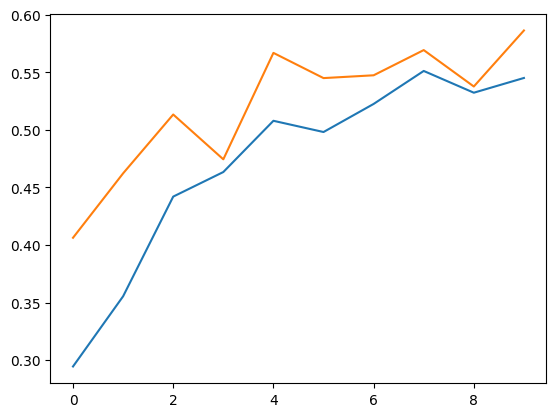

In [ ]:
# summarize history for accuracy
history = historyL_XR
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

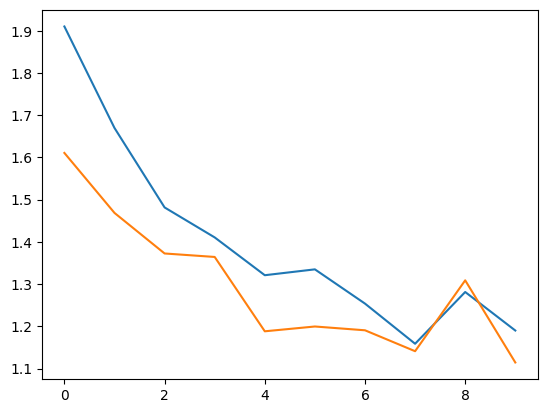

In [ ]:
# summarize history for loss
history = historyL_XR
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


In [ ]:
LSTM_pred = model.predict(XT_test)
LSTM_pred = np.argmax(LSTM_pred, axis=1)
LSTM_pred_df = pd.DataFrame(LSTM_pred,columns = ["Label"])
LSTM_pred_df

yT_labels = np.argmax(yT_test.values, axis=1)
yT_labels = pd.DataFrame(yT_labels,columns = ["Label"])
yT_labels


28/28 [==============================] - 1s 3ms/step


,Label
0,5
1,4
2,5
3,5
4,4
...,...
875,8
876,4
877,4
878,4


----- Classification Report of CNN predict X_test -----
              precision    recall  f1-score   support

           0       0.54      0.61      0.58        31
           1       0.00      0.00      0.00         0
           2       0.40      0.61      0.48        28
           3       0.41      0.37      0.39        54
           4       0.61      0.55      0.58       267
           5       0.49      0.38      0.43       239
           6       0.00      0.00      0.00         0
           7       0.62      0.64      0.63       121
           8       0.67      0.63      0.65        59
           9       0.49      0.46      0.47        81

    accuracy                           0.51       880
   macro avg       0.42      0.42      0.42       880
weighted avg       0.55      0.51      0.52       880

----- Confusion matrix of CNN predict X_test -----
[[ 19   2   2   0   4   4   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   1  17   0   9   1   0   0   0   0]
 [  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

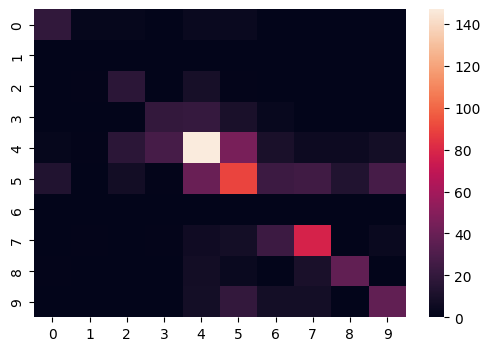

In [ ]:
print('----- Classification Report of CNN predict X_test -----')
print(classification_report(LSTM_pred,yT_labels))
print('----- Confusion matrix of CNN predict X_test -----')
print(confusion_matrix(LSTM_pred,yT_labels))

cm = confusion_matrix(LSTM_pred,yT_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm)